<a href="https://colab.research.google.com/github/Jonikpatel/autocleandata/blob/main/AUTO_DATA_CLEANING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 ADVANCED DATA CLEANING SYSTEM
With MCAR/MAR/MNAR, IQR, MAD, Isolation Forest

📁 Upload your CSV file:


Saving equpment.csv to equpment (1).csv
🔬 ADVANCED DATA ANALYSIS

1️⃣ Analyzing Missingness Mechanisms (MCAR/MAR/MNAR)...
📊 Missing Data Patterns:


<Figure size 1200x600 with 0 Axes>

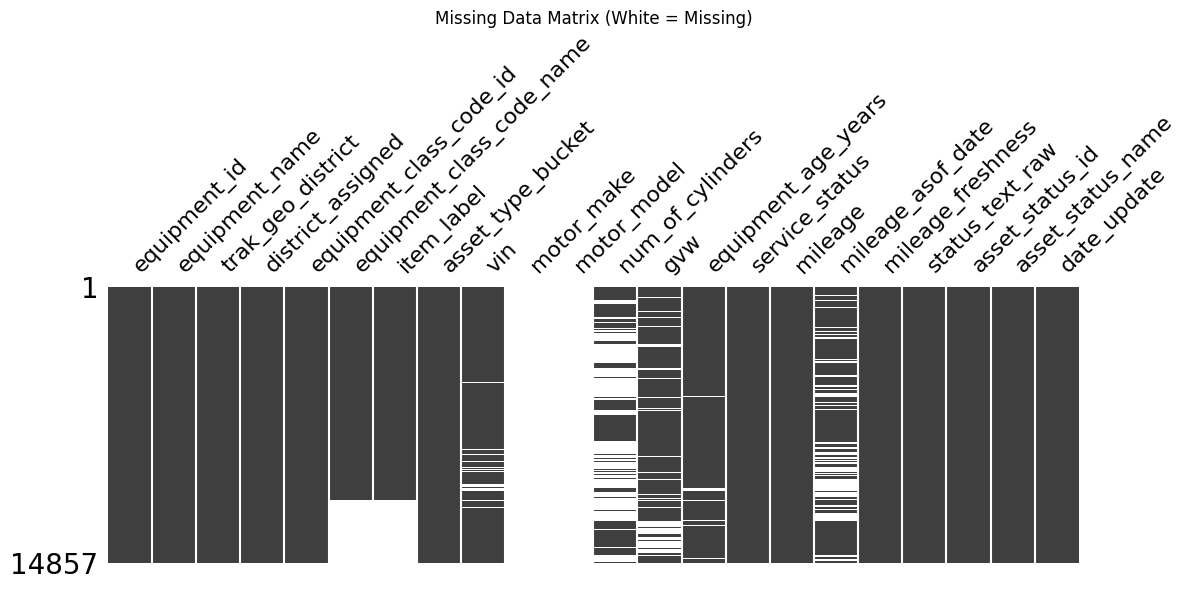

<Figure size 1000x800 with 0 Axes>

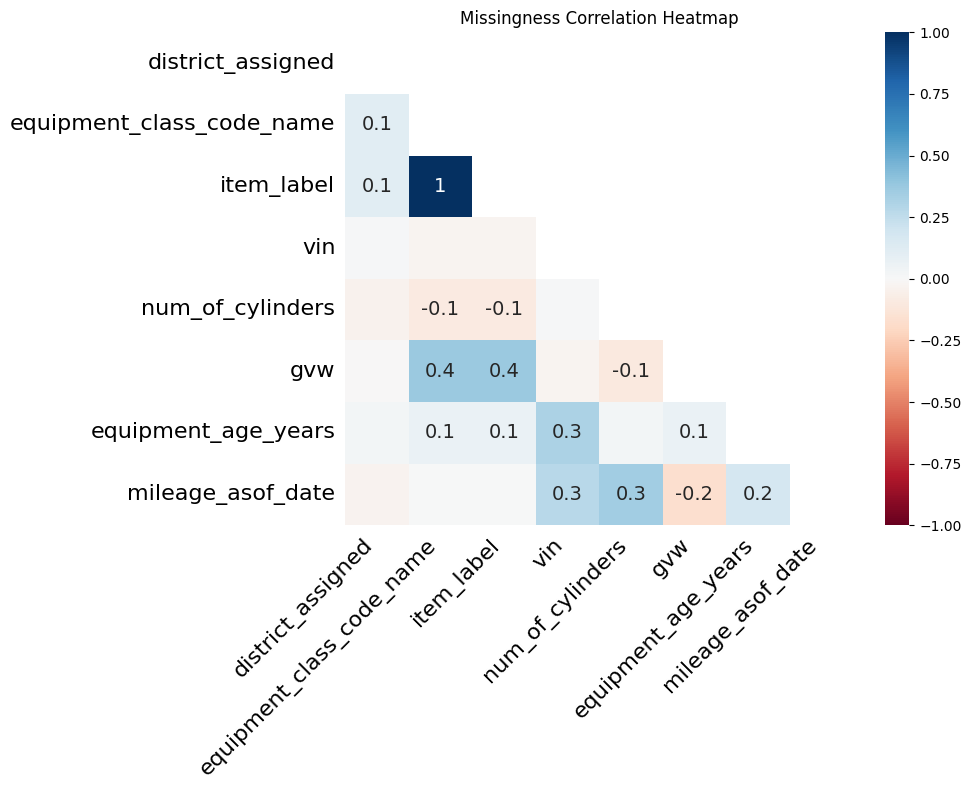


2️⃣ Detecting Outliers (IQR/MAD/Z-Score/Isolation Forest)...

3️⃣ Statistical Profiling...

✅ Analysis Complete!

🧹 INTELLIGENT CLEANING

🔧 Intelligent Imputation (mechanism-aware)...

🎯 Handling Outliers (consensus method)...
  ✓ equipment_id: Capped 1315 outliers
  ✓ gvw: Capped 1056 outliers
  ✓ equipment_age_years: Capped 637 outliers

🔄 Converting Data Types...

✅ Cleaning Complete!

📊 COMPREHENSIVE DATA QUALITY REPORT

📋 OVERVIEW
------------------------------------------------------------
Original Shape: (14857, 22)
Cleaned Shape:  (14857, 23)
Rows Removed:   0
Columns Removed: -1

🔍 MISSINGNESS ANALYSIS (MCAR/MAR/MNAR)
------------------------------------------------------------

district_assigned:
  Mechanism: MNAR (suspected) (Confidence: LOW)
  Missing: 0.4%
  Evidence: Missingness may depend on unobserved values

equipment_class_code_name:
  Mechanism: MAR (Confidence: MEDIUM)
  Missing: 22.8%
  Evidence: Missingness correlates with other variables (r=0.621)

item_label:
 

,equipment_id,equipment_name,trak_geo_district,district_assigned,equipment_class_code_id,equipment_class_code_name,item_label,asset_type_bucket,vin,num_of_cylinders,...,mileage,mileage_asof_date,mileage_freshness,status_text_raw,asset_status_id,asset_status_name,date_update,district_assigned_was_missing,equipment_age_years_was_missing,mileage_asof_date_was_missing
0,214431.0,0000519,CENTRAL OFFICE,0.0,90.0,TRUCK 1 TON CREW CABS,009A,Vehicle,1GC4KZCG0BF253277,8.0,...,176076.0,2025-10-27T11:26:13,fresh,Available,9.0,AVAL,2023-03-17T13:39:33,0.0,0,0
1,289742.0,0000720,CENTRAL OFFICE,0.0,90.0,TRUCK 1 TON CREW CABS,009A,Vehicle,1GC4KZC86DF168116,8.0,...,240413.0,2022-12-05T13:52:27,fresh,Available,9.0,AVAL,2020-09-11T08:56:46,0.0,0,0
2,420343.0,0000825,CENTRAL OFFICE,0.0,90.0,TRUCK 1 TON CREW CABS,009A,Vehicle,1GC4KZCG6EF140728,8.0,...,61301.0,2025-10-29T14:26:15,fresh,Available,9.0,AVAL,2014-01-15T10:35:36,0.0,0,0
3,427837.0,0000844,DISTRICT 11,11.0,90.0,TRUCK 1 TON CREW CABS,009A,Vehicle,1GC4KZCG3EF141545,8.0,...,116506.0,2025-10-24T15:29:25,fresh,Available,9.0,AVAL,2023-07-19T07:48:42,0.0,0,0
4,427846.0,0000852,DISTRICT 11,11.0,90.0,TRUCK 1 TON CREW CABS,009A,Vehicle,1GC4KZCG8EF146658,8.0,...,82381.0,2025-10-28T12:51:02,fresh,Available,9.0,AVAL,2014-01-15T10:35:47,0.0,0,0


In [4]:


# ============ INSTALLATION ============
!pip install pandas numpy scikit-learn scipy matplotlib seaborn plotly -q
!pip install missingno imbalanced-learn -q

# ============ IMPORTS ============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import chi2_contingency, normaltest, jarque_bera
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
import warnings
import json
from collections import Counter
from google.colab import files
import io
import missingno as msno

warnings.filterwarnings('ignore')

# THEORETICAL CONCEPTS

class MissingnessAnalyzer:
    """
    Analyze missingness mechanisms:
    - MCAR (Missing Completely At Random): Missingness independent of all variables
    - MAR (Missing At Random): Missingness depends on observed data
    - MNAR (Missing Not At Random): Missingness depends on unobserved data
    """

    def __init__(self, df):
        self.df = df
        self.missing_pattern = df.isnull()

    def analyze_mechanism(self):
        """Determine likely missingness mechanism"""
        results = {}

        for col in self.df.columns:
            if self.df[col].isnull().sum() == 0:
                continue

            mechanism = {
                'column': col,
                'missing_count': self.df[col].isnull().sum(),
                'missing_percent': (self.df[col].isnull().sum() / len(self.df)) * 100,
                'mechanism': 'UNKNOWN',
                'evidence': [],
                'confidence': 'LOW'
            }

            # Test for MCAR using Little's MCAR test
            mcar_score = self._test_mcar(col)

            # Test for MAR by checking correlation with other variables
            mar_score = self._test_mar(col)

            # Determine mechanism
            if mcar_score > 0.05 and mar_score < 0.3:
                mechanism['mechanism'] = 'MCAR'
                mechanism['confidence'] = 'MEDIUM'
                mechanism['evidence'].append(f"No significant pattern detected (p={mcar_score:.3f})")
            elif mar_score >= 0.3:
                mechanism['mechanism'] = 'MAR'
                mechanism['confidence'] = 'MEDIUM'
                mechanism['evidence'].append(f"Missingness correlates with other variables (r={mar_score:.3f})")
            else:
                mechanism['mechanism'] = 'MNAR (suspected)'
                mechanism['confidence'] = 'LOW'
                mechanism['evidence'].append("Missingness may depend on unobserved values")

            results[col] = mechanism

        return results

    def _test_mcar(self, col):
        """Simplified MCAR test - checks if missingness is random"""
        missing_indicator = self.df[col].isnull().astype(int)

        # Compare distributions of other numeric variables
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [c for c in numeric_cols if c != col and self.df[c].notna().sum() > 10]

        if len(numeric_cols) == 0:
            return 1.0

        p_values = []
        for other_col in numeric_cols[:5]:  # Test first 5 numeric columns
            try:
                present = self.df[self.df[col].notna()][other_col].dropna()
                missing = self.df[self.df[col].isna()][other_col].dropna()

                if len(present) > 5 and len(missing) > 5:
                    _, p_value = stats.mannwhitneyu(present, missing, alternative='two-sided')
                    p_values.append(p_value)
            except:
                continue

        return np.mean(p_values) if p_values else 1.0

    def _test_mar(self, col):
        """Test if missingness correlates with other variables"""
        missing_indicator = self.df[col].isnull().astype(int)

        correlations = []
        for other_col in self.df.columns:
            if other_col == col:
                continue

            try:
                if self.df[other_col].dtype in [np.float64, np.int64]:
                    corr = np.abs(np.corrcoef(missing_indicator, self.df[other_col].fillna(0))[0, 1])
                    if not np.isnan(corr):
                        correlations.append(corr)
            except:
                continue

        return max(correlations) if correlations else 0.0

    def visualize_patterns(self):
        """Visualize missing data patterns"""
        print("📊 Missing Data Patterns:")

        # Missing data matrix
        plt.figure(figsize=(12, 6))
        msno.matrix(self.df, figsize=(12, 6), sparkline=False)
        plt.title('Missing Data Matrix (White = Missing)')
        plt.tight_layout()
        plt.show()

        # Missing data correlation
        plt.figure(figsize=(10, 8))
        msno.heatmap(self.df, figsize=(10, 8))
        plt.title('Missingness Correlation Heatmap')
        plt.tight_layout()
        plt.show()


class OutlierDetector:
    """
    Multiple outlier detection methods:
    - IQR (Interquartile Range): Classic statistical method
    - MAD (Median Absolute Deviation): Robust to extreme outliers
    - Z-Score: Standard deviations from mean
    - Isolation Forest: ML-based anomaly detection
    - Local Outlier Factor: Density-based detection
    - Elliptic Envelope: Gaussian distribution assumption
    """

    def __init__(self, df):
        self.df = df
        self.numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    def detect_all_methods(self):
        """Apply all outlier detection methods"""
        results = {}

        for col in self.numeric_cols:
            data = self.df[col].dropna()

            if len(data) < 10:
                continue

            outliers = {
                'column': col,
                'total_values': len(data),
                'methods': {}
            }

            # IQR Method
            iqr_outliers = self._detect_iqr(data)
            outliers['methods']['IQR'] = {
                'count': len(iqr_outliers),
                'percent': len(iqr_outliers) / len(data) * 100,
                'indices': iqr_outliers.tolist()
            }

            # MAD Method
            mad_outliers = self._detect_mad(data)
            outliers['methods']['MAD'] = {
                'count': len(mad_outliers),
                'percent': len(mad_outliers) / len(data) * 100,
                'indices': mad_outliers.tolist()
            }

            # Z-Score Method
            zscore_outliers = self._detect_zscore(data)
            outliers['methods']['Z-Score'] = {
                'count': len(zscore_outliers),
                'percent': len(zscore_outliers) / len(data) * 100,
                'indices': zscore_outliers.tolist()
            }

            # Isolation Forest
            if len(data) >= 20:
                iso_outliers = self._detect_isolation_forest(data)
                outliers['methods']['Isolation_Forest'] = {
                    'count': len(iso_outliers),
                    'percent': len(iso_outliers) / len(data) * 100,
                    'indices': iso_outliers.tolist()
                }

            # Consensus outliers (detected by multiple methods)
            all_outliers = set()
            for method_data in outliers['methods'].values():
                all_outliers.update(method_data['indices'])

            # Count how many methods detected each outlier
            outlier_votes = Counter()
            for method_data in outliers['methods'].values():
                for idx in method_data['indices']:
                    outlier_votes[idx] += 1

            # Consensus: detected by at least 2 methods
            consensus_outliers = [idx for idx, votes in outlier_votes.items() if votes >= 2]

            outliers['consensus'] = {
                'count': len(consensus_outliers),
                'percent': len(consensus_outliers) / len(data) * 100,
                'indices': consensus_outliers
            }

            results[col] = outliers

        return results

    def _detect_iqr(self, data):
        """IQR Method: Q1 - 1.5*IQR, Q3 + 1.5*IQR"""
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data < lower_bound) | (data > upper_bound)]
        return outliers.index

    def _detect_mad(self, data):
        """
        MAD (Median Absolute Deviation) Method
        More robust than IQR for extremely skewed distributions
        Threshold: median ± k * MAD (typically k=3)
        """
        median = data.median()
        mad = np.median(np.abs(data - median))

        # Modified Z-score using MAD
        modified_z_scores = 0.6745 * (data - median) / mad if mad != 0 else np.zeros(len(data))

        threshold = 3.5  # Typically 3.5 for MAD
        outliers = data[np.abs(modified_z_scores) > threshold]
        return outliers.index

    def _detect_zscore(self, data):
        """Z-Score Method: |Z| > 3"""
        mean = data.mean()
        std = data.std()

        if std == 0:
            return pd.Index([])

        z_scores = np.abs((data - mean) / std)
        outliers = data[z_scores > 3]
        return outliers.index

    def _detect_isolation_forest(self, data):
        """
        Isolation Forest: ML-based anomaly detection
        Isolates observations by randomly selecting a feature and split value
        Anomalies are easier to isolate (fewer splits needed)
        """
        try:
            iso_forest = IsolationForest(
                contamination=0.1,  # Expected proportion of outliers
                random_state=42,
                n_estimators=100
            )

            data_2d = data.values.reshape(-1, 1)
            predictions = iso_forest.fit_predict(data_2d)

            # -1 indicates outlier
            outlier_indices = data.index[predictions == -1]
            return outlier_indices
        except:
            return pd.Index([])

    def visualize_outliers(self, col, results):
        """Visualize outliers for a specific column"""
        if col not in results:
            print(f"No outlier data for {col}")
            return

        data = self.df[col].dropna()
        outlier_data = results[col]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Outlier Detection for {col}', fontsize=16, fontweight='bold')

        # Box plot with different methods
        for idx, (method, color) in enumerate([
            ('IQR', 'red'),
            ('MAD', 'orange'),
            ('Z-Score', 'purple'),
            ('consensus', 'darkred')
        ]):
            ax = axes[idx // 2, idx % 2]

            ax.boxplot(data, vert=False)

            if method in outlier_data['methods']:
                outlier_indices = outlier_data['methods'][method]['indices']
            elif method == 'consensus':
                outlier_indices = outlier_data['consensus']['indices']
            else:
                outlier_indices = []

            outlier_values = data.loc[outlier_indices]

            ax.scatter(outlier_values, [1] * len(outlier_values),
                      color=color, s=100, alpha=0.6, label=f'{method} outliers')
            ax.set_title(f'{method}: {len(outlier_indices)} outliers ({len(outlier_indices)/len(data)*100:.1f}%)')
            ax.set_xlabel('Value')
            ax.legend()

        plt.tight_layout()
        plt.show()


class AdvancedImputer:
    """
    Advanced imputation strategies based on missingness mechanism:
    - MCAR: Simple strategies (mean, median, mode) are unbiased
    - MAR: Use relationships with other variables (KNN, regression)
    - MNAR: Domain knowledge required, flag imputed values
    """

    def __init__(self, df, missingness_analysis):
        self.df = df.copy()
        self.missingness_analysis = missingness_analysis

    def impute_intelligent(self):
        """Impute based on missingness mechanism"""
        imputed_df = self.df.copy()
        imputation_log = []

        for col, analysis in self.missingness_analysis.items():
            if analysis['missing_count'] == 0:
                continue

            mechanism = analysis['mechanism']
            missing_percent = analysis['missing_percent']

            # Don't impute if too much missing (>70%)
            if missing_percent > 70:
                imputation_log.append({
                    'column': col,
                    'action': 'DROPPED',
                    'reason': f'{missing_percent:.1f}% missing - too high',
                    'mechanism': mechanism
                })
                imputed_df = imputed_df.drop(columns=[col])
                continue

            # Choose imputation strategy based on mechanism
            if mechanism == 'MCAR':
                # Simple imputation is unbiased for MCAR
                strategy = self._impute_mcar(imputed_df, col)
                imputation_log.append({
                    'column': col,
                    'action': 'IMPUTED',
                    'method': strategy,
                    'mechanism': 'MCAR',
                    'reason': 'Simple imputation (unbiased for MCAR)'
                })

            elif mechanism == 'MAR':
                # Use relationships with other variables
                strategy = self._impute_mar(imputed_df, col)
                imputation_log.append({
                    'column': col,
                    'action': 'IMPUTED',
                    'method': strategy,
                    'mechanism': 'MAR',
                    'reason': 'Advanced imputation using related variables'
                })

            else:  # MNAR
                # Flag imputed values and use conservative approach
                strategy = self._impute_mnar(imputed_df, col)
                imputation_log.append({
                    'column': col,
                    'action': 'IMPUTED (FLAGGED)',
                    'method': strategy,
                    'mechanism': 'MNAR (suspected)',
                    'reason': 'Conservative imputation + missing indicator'
                })

        return imputed_df, imputation_log

    def _impute_mcar(self, df, col):
        """Impute MCAR data - simple methods are unbiased"""
        if df[col].dtype in [np.float64, np.int64]:
            # Check for outliers
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outlier_count = ((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)).sum()

            if outlier_count / df[col].notna().sum() > 0.1:
                # Use median if many outliers
                fill_value = df[col].median()
                df[col].fillna(fill_value, inplace=True)
                return f'Median ({fill_value:.2f})'
            else:
                # Use mean otherwise
                fill_value = df[col].mean()
                df[col].fillna(fill_value, inplace=True)
                return f'Mean ({fill_value:.2f})'
        else:
            # Mode for categorical
            mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_value, inplace=True)
            return f"Mode ('{mode_value}')"

    def _impute_mar(self, df, col):
        """Impute MAR data - use KNN or regression"""
        if df[col].dtype in [np.float64, np.int64]:
            # KNN Imputation
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

            if len(numeric_cols) >= 3:
                try:
                    imputer = KNNImputer(n_neighbors=5, weights='distance')
                    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
                    return 'KNN (k=5, distance-weighted)'
                except:
                    # Fallback to median
                    fill_value = df[col].median()
                    df[col].fillna(fill_value, inplace=True)
                    return f'Median fallback ({fill_value:.2f})'
            else:
                fill_value = df[col].median()
                df[col].fillna(fill_value, inplace=True)
                return f'Median ({fill_value:.2f})'
        else:
            # Most frequent for categorical
            mode_value = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_value, inplace=True)
            return f"Most Frequent ('{mode_value}')"

    def _impute_mnar(self, df, col):
        """Impute MNAR data - conservative approach with flag"""
        # Create missing indicator
        df[f'{col}_was_missing'] = df[col].isnull().astype(int)

        # Use conservative imputation
        if df[col].dtype in [np.float64, np.int64]:
            fill_value = df[col].median()
            df[col].fillna(fill_value, inplace=True)
            return f'Median ({fill_value:.2f}) + Missing Flag'
        else:
            df[col].fillna('MISSING_VALUE', inplace=True)
            return "'MISSING_VALUE' + Missing Flag"


class StatisticalProfiler:
    """
    Advanced statistical profiling:
    - Distribution tests (normality, skewness, kurtosis)
    - Multivariate analysis
    - Feature interactions
    - Data drift detection
    """

    def __init__(self, df):
        self.df = df

    def profile_distributions(self):
        """Profile statistical distributions"""
        results = {}

        for col in self.df.select_dtypes(include=[np.number]).columns:
            data = self.df[col].dropna()

            if len(data) < 8:
                continue

            profile = {
                'column': col,
                'count': len(data),
                'mean': float(data.mean()),
                'median': float(data.median()),
                'std': float(data.std()),
                'skewness': float(data.skew()),
                'kurtosis': float(data.kurtosis()),
            }

            # Test for normality
            try:
                _, p_value = normaltest(data)
                profile['normality_test'] = {
                    'p_value': float(p_value),
                    'is_normal': p_value > 0.05,
                    'interpretation': 'Normal' if p_value > 0.05 else 'Non-normal'
                }
            except:
                profile['normality_test'] = None

            # Distribution shape
            if abs(profile['skewness']) < 0.5:
                profile['distribution_shape'] = 'Symmetric'
            elif profile['skewness'] > 0:
                profile['distribution_shape'] = 'Right-skewed (positive)'
            else:
                profile['distribution_shape'] = 'Left-skewed (negative)'

            # Kurtosis interpretation
            if profile['kurtosis'] > 3:
                profile['tail_behavior'] = 'Heavy-tailed (leptokurtic)'
            elif profile['kurtosis'] < -1:
                profile['tail_behavior'] = 'Light-tailed (platykurtic)'
            else:
                profile['tail_behavior'] = 'Normal tails (mesokurtic)'

            results[col] = profile

        return results


#  INTEGRATED SYSTEM

class AdvancedDataCleaner:
    """Integrated advanced data cleaning system"""

    def __init__(self, df):
        self.df = df.copy()
        self.original_df = df.copy()
        self.reports = {}

    def analyze(self):
        """Complete data analysis"""
        print("🔬 ADVANCED DATA ANALYSIS")
        print("="*60)

        # 1. Missingness Analysis
        print("\n1️⃣ Analyzing Missingness Mechanisms (MCAR/MAR/MNAR)...")
        missingness = MissingnessAnalyzer(self.df)
        self.reports['missingness'] = missingness.analyze_mechanism()
        missingness.visualize_patterns()

        # 2. Outlier Detection
        print("\n2️⃣ Detecting Outliers (IQR/MAD/Z-Score/Isolation Forest)...")
        outlier_detector = OutlierDetector(self.df)
        self.reports['outliers'] = outlier_detector.detect_all_methods()

        # 3. Statistical Profiling
        print("\n3️⃣ Statistical Profiling...")
        stat_profiler = StatisticalProfiler(self.df)
        self.reports['distributions'] = stat_profiler.profile_distributions()

        print("\n✅ Analysis Complete!")
        return self.reports

    def clean(self):
        """Execute intelligent cleaning"""
        print("\n🧹 INTELLIGENT CLEANING")
        print("="*60)

        cleaning_log = []

        # 1. Remove exact duplicates
        before = len(self.df)
        self.df = self.df.drop_duplicates()
        after = len(self.df)
        if before != after:
            cleaning_log.append({
                'step': 'Remove Duplicates',
                'details': f'Removed {before-after} exact duplicate rows',
                'impact': f'{before} → {after} rows'
            })
            print(f"✓ Removed {before-after} duplicates")

        # 2. Intelligent imputation based on missingness mechanism
        print("\n🔧 Intelligent Imputation (mechanism-aware)...")
        imputer = AdvancedImputer(self.df, self.reports['missingness'])
        self.df, imputation_log = imputer.impute_intelligent()
        cleaning_log.extend([{'step': 'Imputation', **log} for log in imputation_log])

        # 3. Handle outliers using consensus method
        print("\n🎯 Handling Outliers (consensus method)...")
        outlier_log = self._handle_outliers_consensus()
        cleaning_log.extend(outlier_log)

        # 4. Type conversion
        print("\n🔄 Converting Data Types...")
        self._convert_types()

        print("\n✅ Cleaning Complete!")
        return self.df, cleaning_log

    def _handle_outliers_consensus(self):
        """Handle outliers using consensus from multiple methods"""
        log = []

        for col, outlier_data in self.reports['outliers'].items():
            consensus = outlier_data['consensus']

            if consensus['percent'] < 1:  # Skip if <1% outliers
                continue

            if consensus['percent'] > 20:  # Too many outliers - might be valid data
                log.append({
                    'step': 'Outlier Check',
                    'column': col,
                    'action': 'SKIPPED',
                    'reason': f'{consensus["percent"]:.1f}% outliers - likely valid variation'
                })
                continue

            # Cap outliers using IQR method
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            original_outliers = consensus['count']
            self.df[col] = self.df[col].clip(lower=lower_bound, upper=upper_bound)

            log.append({
                'step': 'Cap Outliers',
                'column': col,
                'action': 'CAPPED',
                'method': 'Consensus (multiple methods)',
                'details': f'Capped {original_outliers} outliers to [{lower_bound:.2f}, {upper_bound:.2f}]'
            })

            print(f"  ✓ {col}: Capped {original_outliers} outliers")

        return log

    def _convert_types(self):
        """Convert to appropriate data types"""
        for col in self.df.columns:
            # Try to convert to numeric
            try:
                if self.df[col].dtype == 'object':
                    converted = pd.to_numeric(self.df[col], errors='coerce')
                    if converted.notna().sum() / len(self.df) > 0.9:
                        self.df[col] = converted
            except:
                pass

    def generate_report(self, cleaned_df, cleaning_log):
        """Generate comprehensive report"""
        print("\n" + "="*60)
        print("📊 COMPREHENSIVE DATA QUALITY REPORT")
        print("="*60)

        # Overview
        print("\n📋 OVERVIEW")
        print("-"*60)
        print(f"Original Shape: {self.original_df.shape}")
        print(f"Cleaned Shape:  {cleaned_df.shape}")
        print(f"Rows Removed:   {len(self.original_df) - len(cleaned_df)}")
        print(f"Columns Removed: {len(self.original_df.columns) - len(cleaned_df.columns)}")

        # Missingness Report
        print("\n🔍 MISSINGNESS ANALYSIS (MCAR/MAR/MNAR)")
        print("-"*60)
        for col, analysis in self.reports['missingness'].items():
            print(f"\n{col}:")
            print(f"  Mechanism: {analysis['mechanism']} (Confidence: {analysis['confidence']})")
            print(f"  Missing: {analysis['missing_percent']:.1f}%")
            for evidence in analysis['evidence']:
                print(f"  Evidence: {evidence}")

        # Outlier Report
        print("\n📊 OUTLIER DETECTION SUMMARY")
        print("-"*60)
        for col, data in self.reports['outliers'].items():
            print(f"\n{col}:")
            for method, result in data['methods'].items():
                print(f"  {method:20s}: {result['count']:3d} outliers ({result['percent']:.1f}%)")
            print(f"  {'CONSENSUS':20s}: {data['consensus']['count']:3d} outliers ({data['consensus']['percent']:.1f}%)")

        # Distribution Report
        print("\n📈 STATISTICAL DISTRIBUTIONS")
        print("-"*60)
        for col, profile in self.reports['distributions'].items():
            print(f"\n{col}:")
            print(f"  Shape: {profile['distribution_shape']}")
            print(f"  Tails: {profile['tail_behavior']}")
            print(f"  Skewness: {profile['skewness']:.3f}")
            print(f"  Kurtosis: {profile['kurtosis']:.3f}")
            if profile['normality_test']:
                print(f"  Normality: {profile['normality_test']['interpretation']} (p={profile['normality_test']['p_value']:.4f})")

        # Cleaning Log
        print("\n🧹 CLEANING OPERATIONS LOG")
        print("-"*60)
        for i, log in enumerate(cleaning_log, 1):
            print(f"\n{i}. {log['step']}")
            for key, value in log.items():
                if key != 'step':
                    print(f"   {key}: {value}")

        # Quality Metrics
        print("\n✨ QUALITY IMPROVEMENT")
        print("-"*60)
        original_complete = (1 - self.original_df.isnull().sum().sum() /
                           (len(self.original_df) * len(self.original_df.columns))) * 100
        cleaned_complete = (1 - cleaned_df.isnull().sum().sum() /
                          (len(cleaned_df) * len(cleaned_df.columns))) * 100

        print(f"Completeness: {original_complete:.1f}% → {cleaned_complete:.1f}%")
        print(f"Improvement:  +{cleaned_complete - original_complete:.1f}%")


# ============ MAIN EXECUTION ============

def main():
    """Main execution with advanced concepts"""

    print("="*60)
    print("🚀 ADVANCED DATA CLEANING SYSTEM")
    print("With MCAR/MAR/MNAR, IQR, MAD, Isolation Forest")
    print("="*60)
    print("\n📁 Upload your CSV file:")

    # Upload
    uploaded = files.upload()
    if not uploaded:
        return

    # Load
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

    # Analyze and Clean
    cleaner = AdvancedDataCleaner(df)
    reports = cleaner.analyze()
    cleaned_df, cleaning_log = cleaner.clean()

    # Generate Report
    cleaner.generate_report(cleaned_df, cleaning_log)

    # Display cleaned data
    print("\n✅ Cleaned Data Preview:")
    display(cleaned_df.head())


if __name__ == "__main__":
    main()